# **basic arc diagram**

Installing package into 'C:/Users/Lenovo/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'colormap' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Lenovo\AppData\Local\Temp\RtmpmednRX\downloaded_packages


-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

<U+221A> ggplot2 3.2.1     <U+221A> purrr   0.3.3
<U+221A> tibble  2.1.3     <U+221A> dplyr   0.8.3
<U+221A> tidyr   1.0.0     <U+221A> stringr 1.4.0
<U+221A> readr   1.3.1     <U+221A> forcats 0.4.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: viridisLite

NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.

      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and

      if Arial Narrow is not on your system, please see http://bit.ly/arialnarrow


Attaching package: 'igraph'


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:purrr':

    compose, simplify


The following object is masked from 'package:tidyr':

    c

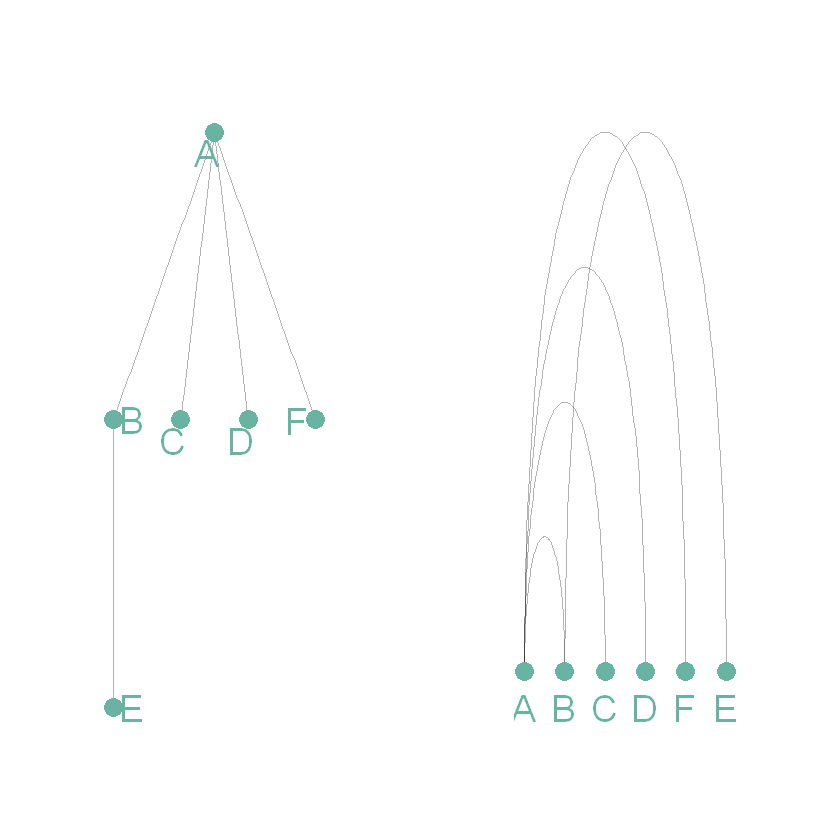

In [2]:
install.packages("colormap")
# Libraries
library(tidyverse)
library(viridis)
library(patchwork)
library(hrbrthemes)
library(igraph)
library(ggraph)
library(colormap)

# A really simple edge list
links=data.frame(
    source=c("A", "A", "A", "A", "B"),
    target=c("B", "C", "D", "F","E")
    )

# Transform to a igraph object
mygraph <- graph_from_data_frame(links)

# Make the usual network diagram
p1 <-  ggraph(mygraph) + 
  geom_edge_link(edge_colour="black", edge_alpha=0.3, edge_width=0.2) +
  geom_node_point( color="#69b3a2", size=5) +
  geom_node_text( aes(label=name), repel = TRUE, size=8, color="#69b3a2") +
  theme_void() +
  theme(
    legend.position="none",
    plot.margin=unit(rep(2,4), "cm")
  ) 

# Make a cord diagram
p2 <-  ggraph(mygraph, layout="linear") + 
  geom_edge_arc(edge_colour="black", edge_alpha=0.3, edge_width=0.2) +
  geom_node_point( color="#69b3a2", size=5) +
  geom_node_text( aes(label=name), repel = FALSE, size=8, color="#69b3a2", nudge_y=-0.1) +
  theme_void() +
  theme(
    legend.position="none",
    plot.margin=unit(rep(2,4), "cm")
  ) 

p1 + p2

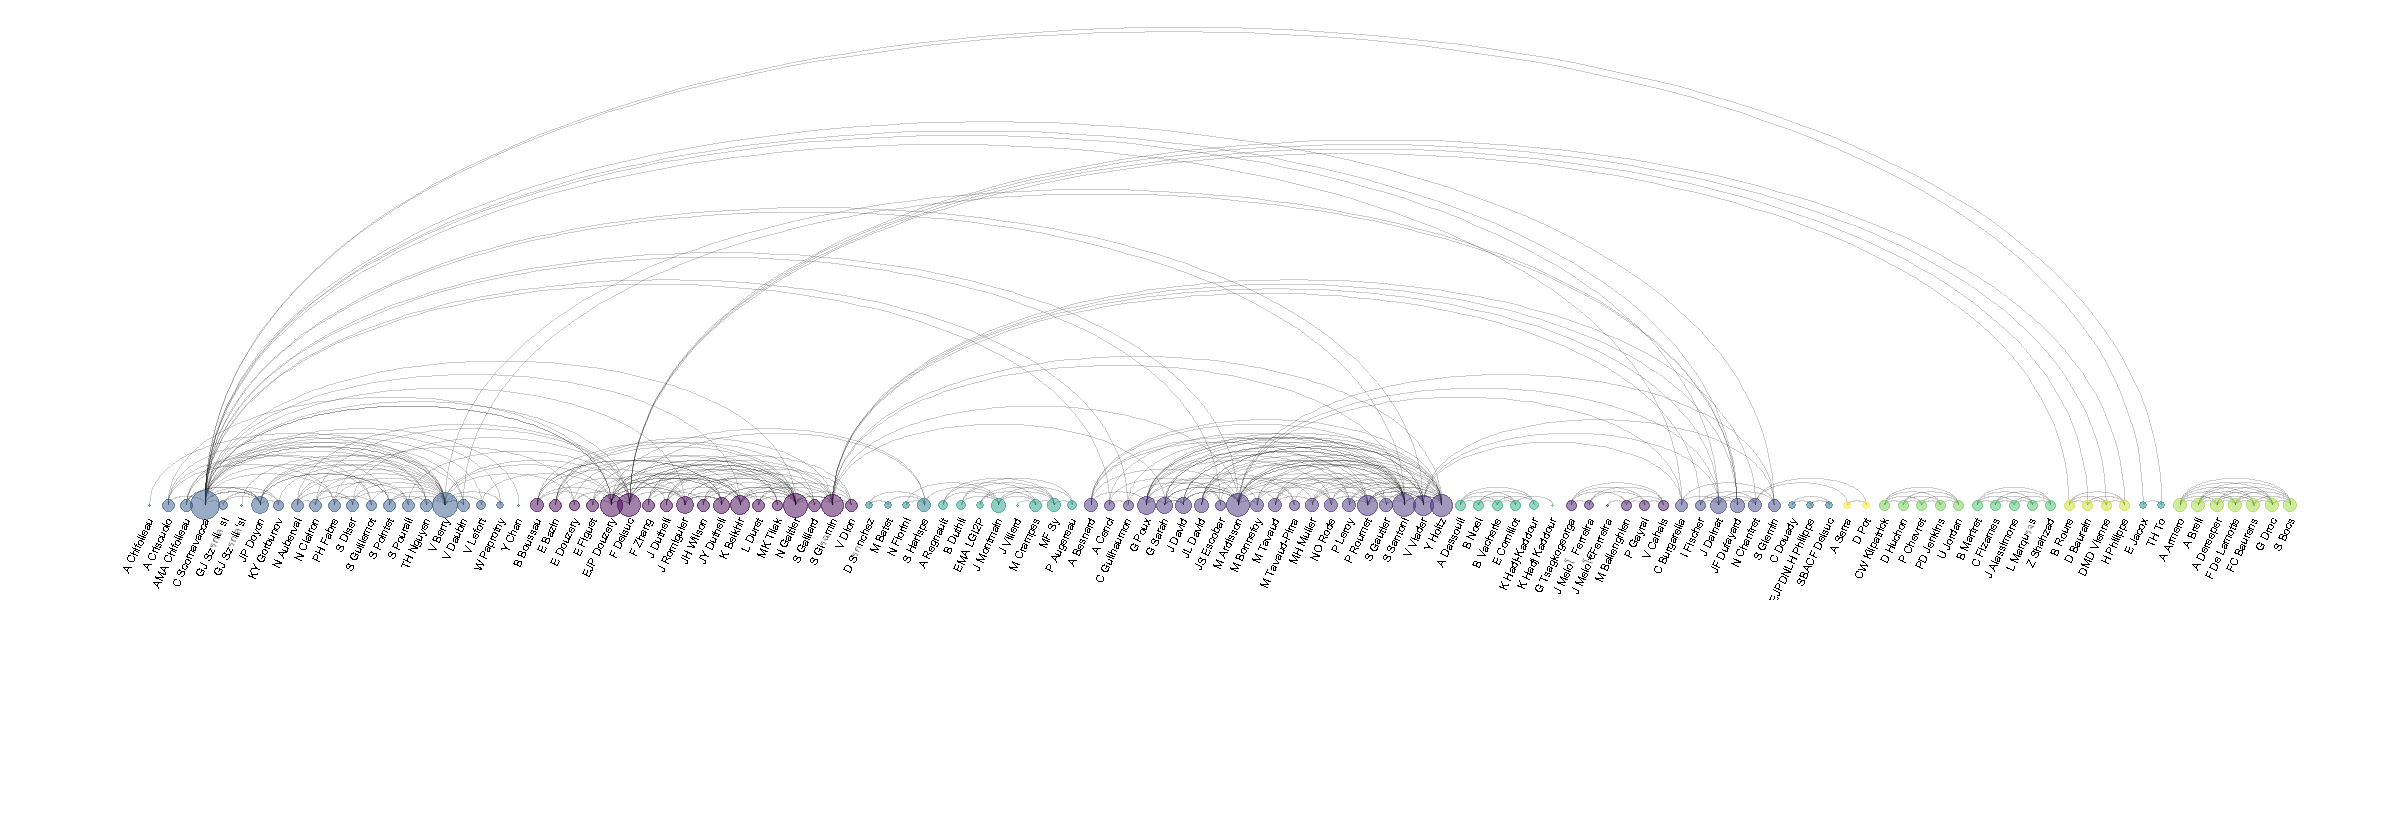

In [5]:
# Load data
dataUU <- read.table("https://raw.githubusercontent.com/holtzy/data_to_viz/master/Example_dataset/13_AdjacencyUndirectedUnweighted.csv", header=TRUE)

# Transform the adjacency matrix in a long format
connect <- dataUU %>% 
  gather(key="to", value="value", -1) %>%
  mutate(to = gsub("\\.", " ",to)) %>%
  na.omit() 

# Number of connection per person
c( as.character(connect$from), as.character(connect$to)) %>%
  as.tibble() %>%
  group_by(value) %>%
  summarize(n=n()) -> coauth
colnames(coauth) <- c("name", "n")
#dim(coauth)

# Create a graph object with igraph
mygraph <- graph_from_data_frame( connect, vertices = coauth, directed = FALSE )

# Find community
com <- walktrap.community(mygraph)
#max(com$membership)

#Reorder dataset and make the graph
coauth <- coauth %>% 
  mutate( grp = com$membership) %>%
  arrange(grp) %>%
  mutate(name=factor(name, name))

# keep only 10 first communities
coauth <- coauth %>% 
  filter(grp<16)

# keep only this people in edges
connect <- connect %>%
  filter(from %in% coauth$name) %>%
  filter(to %in% coauth$name)

# Create a graph object with igraph
mygraph <- graph_from_data_frame( connect, vertices = coauth, directed = FALSE )

# prepare a vector of n color in the viridis scale
mycolor <- colormap(colormap=colormaps$viridis, nshades=max(coauth$grp))
mycolor <- sample(mycolor, length(mycolor))

# Make the graph
ggraph(mygraph, layout="linear") + 
  geom_edge_arc(edge_colour="black", edge_alpha=0.2, edge_width=0.3, fold=TRUE) +
  geom_node_point(aes(size=n, color=as.factor(grp), fill=grp), alpha=0.5) +
  scale_size_continuous(range=c(0.5,8)) +
  scale_color_manual(values=mycolor) +
  geom_node_text(aes(label=name), angle=65, hjust=1, nudge_y = -1.1, size=2.3) +
  theme_void() +
  theme(
    legend.position="none",
    plot.margin=unit(c(0,0,0.4,0), "null"),
    panel.spacing=unit(c(0,0,3.4,0), "null")
  ) +
  expand_limits(x = c(-1.2, 1.2), y = c(-5.6, 1.2)) 
    options(repr.plot.width  = 25, repr.plot.height = 7, repr.plot.res = 120)